In [1]:
options(repos = c(
  reckziegel = "https://reckziegel.r-universe.dev",
  CRAN = "https://cloud.r-project.org"
))

install.packages("ffp", verbose = FALSE)  # No need for type = "binary"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘NlcOptim’





Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.92 loaded



A szükséges csomagok betöltve.

--- 1. Adatok betöltése és előkészítése ---
Sikeresen betöltve 5000 szcenárió 14 változóra.

--- 2. Származtatott változók létrehozása a nézetekhez ---
Származtatott változók (hozam/átlag szint) létrehozva minden faktorra.

--- 3. Nézetek létrehozása és optimalizáció ---
Létrehozva a GLD intervallum nézet.
Létrehozva a BIL nézet.
Entrópia pooling sikeresen lefutott.

--- 4. Teljes körű verifikáció és bővített elemzés ---

Effektív mintanagyság (ENS): 1676.0 (az eredeti 5000-ből)

Prior vs. Poszterior Bővített Statisztikák:
       Faktor Prior_Atlag Posterior_Atlag Prior_Szoras Posterior_Szoras
5%        BIL     0.02414         0.03390       0.0128          0.00994
5%1       SPY     0.13730         0.15984       0.1182          0.12548
5%2       IWM     0.08793         0.10204       0.1358          0.14445
5%3       VNQ     0.06286         0.05548       0.1497          0.15440
5%4       GLD     0.07814         0.03300       0.1095          0.10945
5%5    

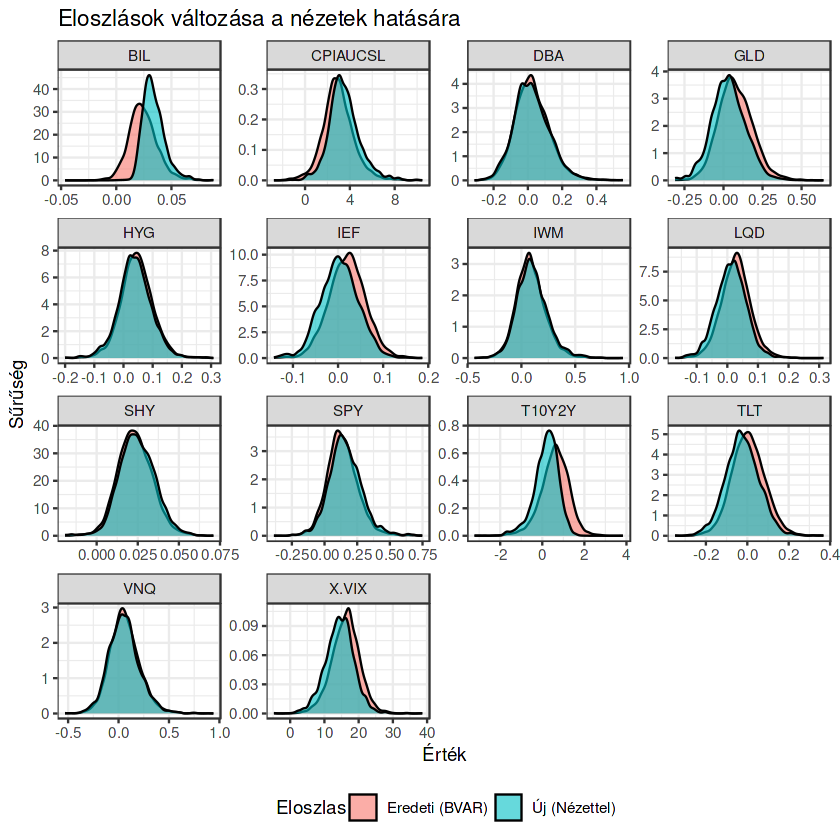

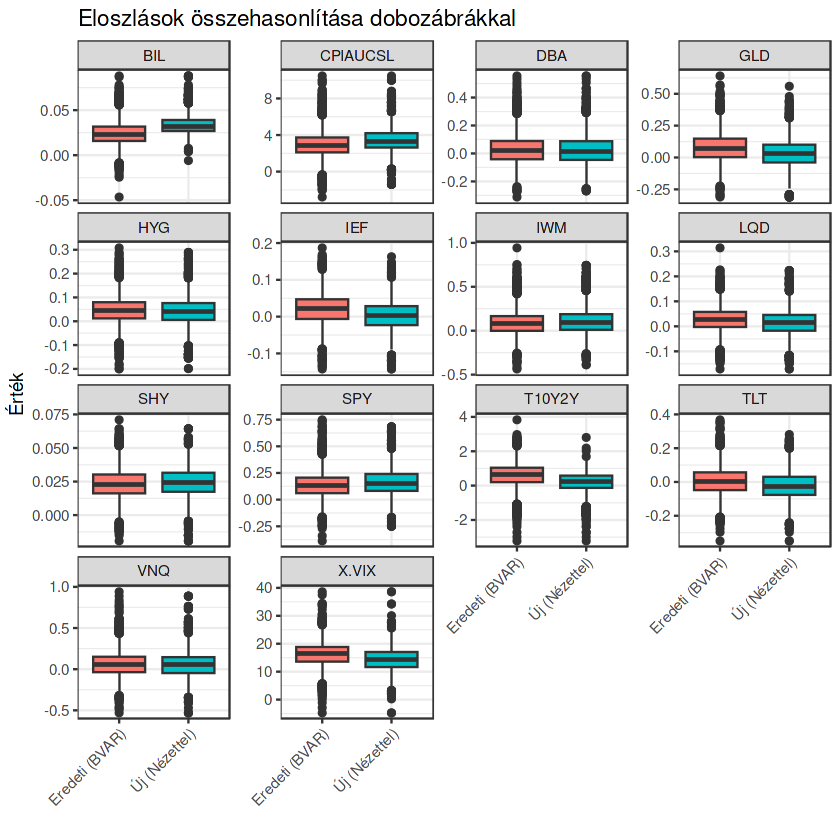

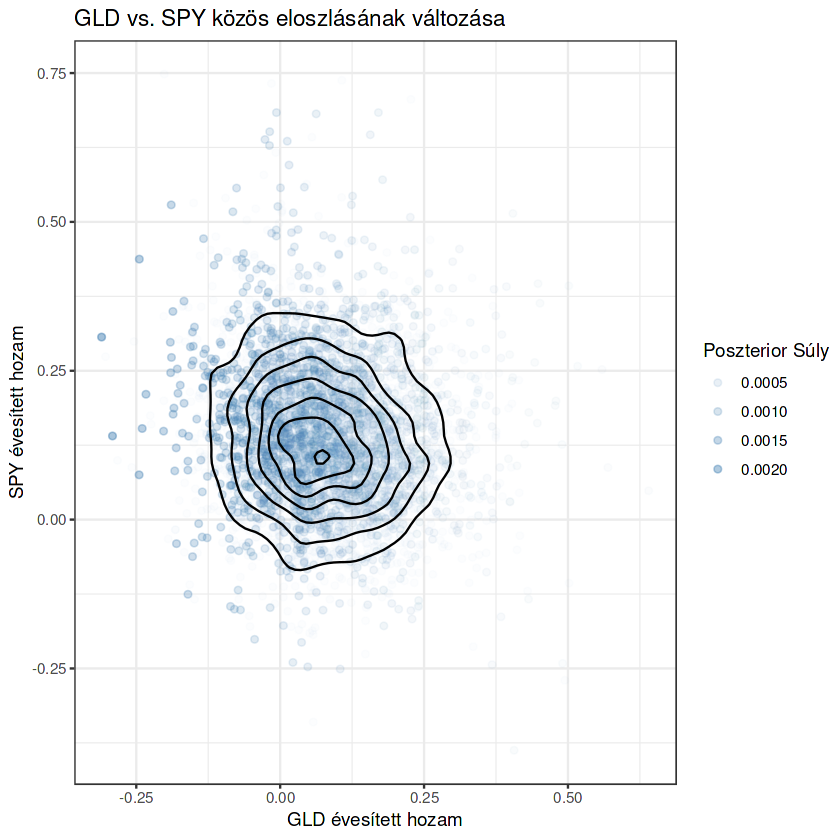

\n--- 5. Eredmények mentése (Python kompatibilis) ---\nA szcenárió tömb sikeresen permutálva a Python-kompatibilis (idő, eszköz, szcenárió) sorrendre.\nÚj dimenziók: 60 x 14 x 5000\n

You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.



\nAz eredmények sikeresen elmentve a 'ep_posterior_for_python.h5' fájlba.\n

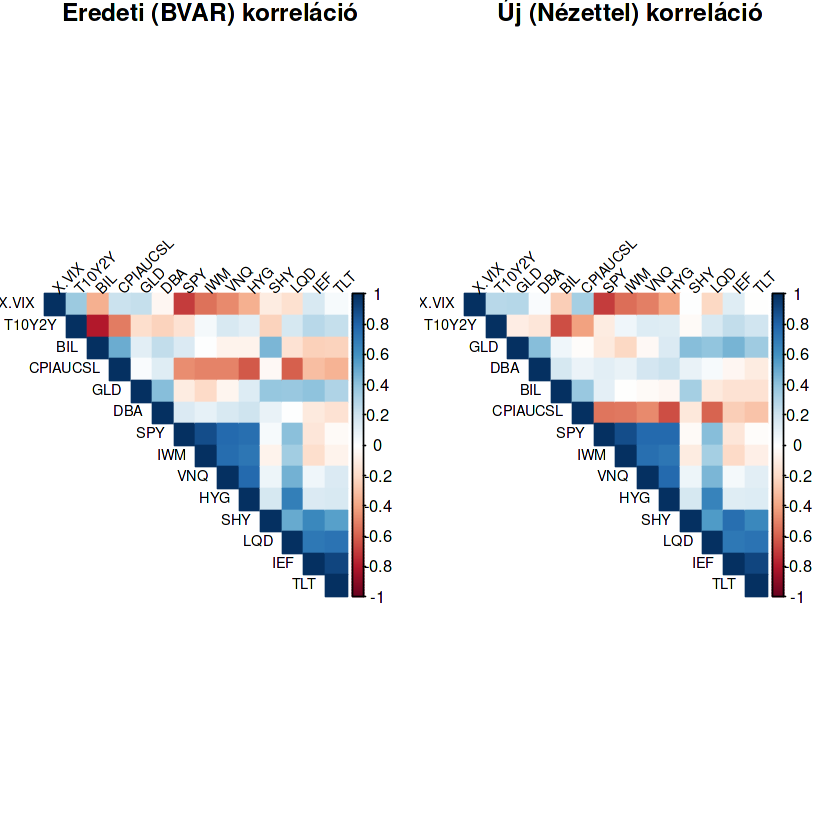

In [2]:
# ==============================================================================
# 0. SZEKCIÓ: KÖRNYEZET BEÁLLÍTÁSA ÉS CSOMAGOK BETÖLTÉSE
# ==============================================================================

# Szükséges csomagok telepítése (ha még nem történt meg)
# install.packages(c("rhdf5", "ffp", "Hmisc", "ggplot2", "dplyr", "tidyr", "corrplot"))

# Csomagok betöltése
library(rhdf5)
library(ffp)
library(Hmisc)
library(ggplot2)
library(dplyr)
library(tidyr)
library(corrplot)

cat("A szükséges csomagok betöltve.\n")


# ==============================================================================
# 1. SZEKCIÓ: ADATOK BETÖLTÉSE ÉS ELŐKÉSZÍTÉSE
# ==============================================================================
cat("\n--- 1. Adatok betöltése és előkészítése ---\n")

h5_path <- "/kaggle/input/bvar-sv-bsvars/eredmenyek_bsvars/ppc_scenarios_bsvars.h5"
ppc_scenarios <- h5read(h5_path, "scenarios")
h5closeAll()
n_draws <- dim(ppc_scenarios)[3]

meta_path <- "/kaggle/input/download-etf-macro-data-in-python/financial_factors_meta.csv.gz"
etf_meta_df <- read.csv(meta_path)
asset_symbols <- etf_meta_df %>%
  filter(type == 'asset_return' | asset_class == 'MACRO') %>%
  pull(symbol) %>% 
  gsub("\\^", "X.", x = .)
dimnames(ppc_scenarios)[[1]] <- asset_symbols
cat(sprintf("Sikeresen betöltve %d szcenárió %d változóra.\n", n_draws, length(asset_symbols)))


# ==============================================================================
# 2. SZEKCIÓ: SZÁRMAZTATOTT VÁLTOZÓK LÉTREHOZÁSA A NÉZETEKHEZ
# ==============================================================================
cat("\n--- 2. Származtatott változók létrehozása a nézetekhez ---\n")

n_steps <- dim(ppc_scenarios)[2]
calculate_annualized_geom_return <- function(monthly_returns_vector, n_steps) {
  prod(1 + monthly_returns_vector)^(12 / n_steps) - 1
}

derived_vars_matrix <- sapply(asset_symbols, function(symbol) {
  symbol_for_meta <- gsub("X.", "^", symbol, fixed = TRUE)
  asset_info <- etf_meta_df[etf_meta_df$symbol == symbol_for_meta, ]
  if (nrow(asset_info) > 0 && asset_info$type == "asset_return") {
    apply(ppc_scenarios[symbol, , ], 2, calculate_annualized_geom_return, n_steps = n_steps)
  } else {
    apply(ppc_scenarios[symbol, , ], 2, mean)
  }
})
cat("Származtatott változók (hozam/átlag szint) létrehozva minden faktorra.\n")


# ==============================================================================
# 3. SZEKCIÓ: NÉZETEK LÉTREHOZÁSA ÉS OPTIMALIZÁCIÓ
# ==============================================================================
cat("\n--- 3. Nézetek létrehozása és optimalizáció ---\n")

# --- 3.1 GLD nézet: Intervallum [2.9%, 3.3%] ---
# Ezt két egyenlőtlenség-feltétellel valósítjuk meg.
gld_returns_vec <- derived_vars_matrix[, "GLD"]

# Felső korlát: E[GLD] <= 0.033
A_gld_upper <- t(as.matrix(gld_returns_vec))
b_gld_upper <- 0.033

# Alsó korlát: E[GLD] >= 0.029  --->  -E[GLD] <= -0.029
A_gld_lower <- t(as.matrix(-gld_returns_vec))
b_gld_lower <- -0.029

cat("Létrehozva a GLD intervallum nézet.\n")

# --- 3.2 BIL nézet: P(Min hozam < 0) <= 0.01 ---
bil_min_returns <- apply(ppc_scenarios["BIL", , ], 2, min)
A_bil <- t(as.matrix(ifelse(bil_min_returns < 0, 1, 0)))
b_bil <- 0.01
cat("Létrehozva a BIL nézet.\n")


# --- 3.3 Nézetek egyesítése és optimalizáció ---
# Az összes egyenlőtlenség-feltétel összefűzése
A_combined <- rbind(A_bil, A_gld_upper, A_gld_lower)
b_combined <- c(b_bil, b_gld_upper, b_gld_lower)

prior_p <- rep(1 / n_draws, n_draws)
# Mivel már nincs egyenlőség-feltétel, az Aeq és beq argumentum NULL
posterior_p <- entropy_pooling(
  p = prior_p, 
  A = A_combined, 
  b = b_combined,
  Aeq = NULL,
  beq = NULL,
  solver = "solnl"
)
posterior_p_numeric <- as.numeric(posterior_p)
cat("Entrópia pooling sikeresen lefutott.\n")


# ==============================================================================
# 4. SZEKCIÓ: TELJES KÖRŰ VERIFIKÁCIÓ ÉS BŐVÍTETT ELEMZÉS
# ==============================================================================
cat("\n--- 4. Teljes körű verifikáció és bővített elemzés ---\n")

# --- 4.1 Effektív Mintanagyság (ENS) ---
ens <- 1 / sum(posterior_p_numeric^2)
cat(sprintf("\nEffektív mintanagyság (ENS): %.1f (az eredeti %d-ből)\n", ens, n_draws))

# --- 4.2 Bővített statisztikák táblázatos formában ---
weighted.sd <- function(x, w) { mu <- weighted.mean(x, w); sqrt(sum(w * (x - mu)^2)) }
weighted.skewness <- function(x, w) { mu <- weighted.mean(x, w); sd <- weighted.sd(x, w); if (sd < 1e-9) return(NA); sum(w * ((x - mu) / sd)^3) }
weighted.kurtosis <- function(x, w) { mu <- weighted.mean(x, w); sd <- weighted.sd(x, w); if (sd < 1e-9) return(NA); sum(w * ((x - mu) / sd)^4) }
stats_summary_list <- lapply(asset_symbols, function(symbol) {
  x <- derived_vars_matrix[, symbol]
  data.frame(Faktor=symbol, Prior_Atlag=Hmisc::wtd.mean(x, prior_p), Posterior_Atlag=Hmisc::wtd.mean(x, posterior_p_numeric),
             Prior_Szoras=weighted.sd(x, prior_p), Posterior_Szoras=weighted.sd(x, posterior_p_numeric), Prior_Ferdeseg=weighted.skewness(x, prior_p),
             Posterior_Ferdeseg=weighted.skewness(x, posterior_p_numeric), Prior_Csucsossag=weighted.kurtosis(x, prior_p), Posterior_Csucsossag=weighted.kurtosis(x, posterior_p_numeric),
             Prior_VaR_5pct=Hmisc::wtd.quantile(x, prior_p, probs = 0.05), Posterior_VaR_5pct=Hmisc::wtd.quantile(x, posterior_p_numeric, probs = 0.05))
})
stats_summary <- do.call(rbind, stats_summary_list)
cat("\nPrior vs. Poszterior Bővített Statisztikák:\n")
print(format(stats_summary, digits = 3, nsmall = 3))

# --- 4.3 Facetált sűrűségábrák ---
df_prior_long <- as.data.frame(derived_vars_matrix) %>% mutate(Suly = prior_p, Eloszlas = "Eredeti (BVAR)") %>% pivot_longer(cols = all_of(asset_symbols), names_to = "Faktor", values_to = "Ertek")
df_posterior_long <- as.data.frame(derived_vars_matrix) %>% mutate(Suly = posterior_p_numeric, Eloszlas = "Új (Nézettel)") %>% pivot_longer(cols = all_of(asset_symbols), names_to = "Faktor", values_to = "Ertek")
plot_df_long <- rbind(df_prior_long, df_posterior_long)

p_all_densities <- ggplot(plot_df_long, aes(x = Ertek, weight = Suly, fill = Eloszlas)) +
  geom_density(alpha = 0.6) + facet_wrap(~ Faktor, scales = "free") +
  labs(title = "Eloszlások változása a nézetek hatására", x = "Érték", y = "Sűrűség") +
  theme_bw() + theme(legend.position = "bottom")

# --- 4.4 Facetált dobozábrák ---
resample_idx <- sample(1:n_draws, size = n_draws, replace = TRUE, prob = posterior_p_numeric)
df_prior_boxplot <- as.data.frame(derived_vars_matrix) %>% mutate(Eloszlas = "Eredeti (BVAR)") %>% pivot_longer(cols = all_of(asset_symbols), names_to = "Faktor", values_to = "Ertek")
df_posterior_boxplot <- as.data.frame(derived_vars_matrix[resample_idx, ]) %>% mutate(Eloszlas = "Új (Nézettel)") %>% pivot_longer(cols = all_of(asset_symbols), names_to = "Faktor", values_to = "Ertek")
plot_df_boxplot <- rbind(df_prior_boxplot, df_posterior_boxplot)

p_all_boxplots <- ggplot(plot_df_boxplot, aes(y = Ertek, x = Eloszlas, fill = Eloszlas)) +
  geom_boxplot() + facet_wrap(~ Faktor, scales = "free_y") +
  labs(title = "Eloszlások összehasonlítása dobozábrákkal", y = "Érték", x = "") +
  theme_bw() + theme(legend.position = "none", axis.text.x = element_text(angle=45, hjust=1))

# --- 4.5 Korrelogramok és páronkénti ábrák ---
prior_corr <- cov2cor(stats::cov.wt(derived_vars_matrix, wt = prior_p)$cov)
posterior_corr <- cov2cor(stats::cov.wt(derived_vars_matrix, wt = posterior_p_numeric)$cov)
scatter_df <- data.frame(GLD = derived_vars_matrix[, "GLD"], SPY = derived_vars_matrix[, "SPY"], posterior_w = posterior_p_numeric)
p_scatter <- ggplot(scatter_df, aes(x = GLD, y = SPY)) +
  geom_point(aes(alpha = posterior_w), color = "steelblue", size = 1.5) + scale_alpha_continuous(range = c(0.01, 0.5), name = "Poszterior Súly") +
  geom_density_2d(color = "black", linewidth=0.5) + labs(title = "GLD vs. SPY közös eloszlásának változása", x = "GLD évesített hozam", y = "SPY évesített hozam") +
  theme_bw()

# --- Ábrák megjelenítése ---
print(p_all_densities)
print(p_all_boxplots)
print(p_scatter)
par(mfrow = c(1, 2), mar = c(1, 1, 2, 1))
corrplot(prior_corr, method = "color", type = "upper", order = "hclust", tl.col = "black", tl.srt = 45, tl.cex = 0.7, title = "Eredeti (BVAR) korreláció", mar = c(0, 0, 1, 0))
corrplot(posterior_corr, method = "color", type = "upper", order = "hclust", tl.col = "black", tl.srt = 45, tl.cex = 0.7, title = "Új (Nézettel) korreláció", mar = c(0, 0, 1, 0))
par(mfrow = c(1, 1))

# ==============================================================================
# 5. SZEKCIÓ: EREDMÉNYEK MENTÉSE (PYTHON KOMPATIBILIS VERZIÓ)
# ==============================================================================
cat("\\n--- 5. Eredmények mentése (Python kompatibilis) ---\\n")

# --- 1. Lépés: Adatok előkészítése a mentéshez ---
# A Python (idő, eszköz, szcenárió) sorrendet vár.
# Az eredeti R tömb (eszköz, idő, szcenárió).
# Permutáljuk a tömböt a c(2, 1, 3) sorrend szerint.
scenarios_for_python <- aperm(ppc_scenarios, c(2, 1, 3))

# A dimenzióneveket is frissítjük az új sorrendnek megfelelően
dimnames(scenarios_for_python) <- list(
  Timesteps = dimnames(ppc_scenarios)[[2]],
  Assets = dimnames(ppc_scenarios)[[1]],
  Draws = dimnames(ppc_scenarios)[[3]]
)

cat("A szcenárió tömb sikeresen permutálva a Python-kompatibilis (idő, eszköz, szcenárió) sorrendre.\\n")
cat(sprintf("Új dimenziók: %s\\n", paste(dim(scenarios_for_python), collapse = " x ")))


# --- 2. Lépés: HDF5 fájl írása ---
# A kimeneti fájl nevét átnevezzük, hogy egyértelmű legyen a tartalma
output_h5_path <- "ep_posterior_for_python.h5" 
if(file.exists(output_h5_path)) file.remove(output_h5_path)
h5createFile(output_h5_path)

# A Python kód a "scenarios" nevű dataset-et keresi
h5write(scenarios_for_python, output_h5_path, "scenarios")
# A változók (eszközök + makro faktorok) neveinek mentése
h5write(asset_symbols, output_h5_path, "asset_symbols")

# Elmentjük a posterior valószínűségeket is, hogy a Python kód használni tudja
h5write(as.numeric(posterior_p), output_h5_path, "posterior_probabilities")

h5closeAll()
cat(sprintf("\\nAz eredmények sikeresen elmentve a '%s' fájlba.\\n", output_h5_path))